# GCN for DAVIS 2016

In this notebook, a custom [PyTorch Geometric](https://rusty1s.github.io/pytorch_geometric/build/html/index.html) [InMemoryDataset](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/in_memory_dataset.html#InMemoryDataset) for the DAVIS 2016 dataset is created. The implementation is based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/create_dataset.html). The dataset is then used to train a simple GCN network as a first evaluation based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/introduction.html#learning-methods-on-graphs).

The dataset consists of single PyTorch Geometric [Data](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/data.html#Data) objects which model a single graph with various attributes. For this dataset, a graph for each contour is created. Hereby, each node of the graph represents one contour point. The feature of each node is the OSVOS feature vector from the next frame at this point. Each node is connected to its K nearest neighbours. The feature of each edge is the distance between the nodes it connects. The targets of each node is the translation it undergoes from the current to the next frame.

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler

from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader

from pg_datasets.davis_2016 import DAVIS2016

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Paths & Constants

In [2]:
PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH = 'pg_datasets/DAVIS_2016'
CONTOURS_FOLDERS_PATH = 'DAVIS_2016/DAVIS/Contours/480p'
IMAGES_FOLDERS_PATH = 'DAVIS_2016/DAVIS/JPEGImages/480p'
TRANSLATIONS_FOLDERS_PATH = 'DAVIS_2016/DAVIS/Translations/480p'

SKIP_SEQUENCES = ['bmx-trees', 'bus', 'cows', 'dog-agility', 'horsejump-high', 
                  'horsejump-low', 'kite-walk', 'lucia', 'libby', 'motorbike',
                  'paragliding', 'rhino', 'scooter-gray', 'swing']

UNEQUAL_TRANSLATION_LENGTH = ['surf', 'bmx-bumps']

SKIP_SEQUENCES += UNEQUAL_TRANSLATION_LENGTH

TRAIN_SEQUENCES = ['bear', 'bmx-bumps', 'boat', 'breakdance-flare', 'bus', 
                   'car-turn', 'dance-jump', 'dog-agility', 'drift-turn', 
                   'elephant', 'flamingo', 'hike', 'hockey', 'horsejump-low', 
                   'kite-walk', 'lucia', 'mallard-fly', 'mallard-water', 
                   'motocross-bumps', 'motorbike', 'paragliding', 'rhino', 
                   'rollerblade', 'scooter-gray', 'soccerball', 'stroller',
                   'surf', 'swing', 'tennis', 'train']

VAL_SEQUENCES = ['blackswan', 'bmx-trees', 'breakdance', 'camel', 'car-roundabout',
                 'car-shadow', 'cows', 'dance-twirl', 'dog', 'drift-chicane', 
                 'drift-straight', 'goat', 'horsejump-high', 'kite-surf', 'libby', 
                 'motocross-jump', 'paragliding-launch', 'parkour', 'scooter-black', 
                 'soapbox']

BATCH_SIZE = 16
LAYER = 9
K = 32
EPOCHS_WO_AVEGRAD = 5

## Train and Val Dataset

In [3]:
train = DAVIS2016(PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH, 
                  CONTOURS_FOLDERS_PATH, IMAGES_FOLDERS_PATH, TRANSLATIONS_FOLDERS_PATH, 
                  LAYER, K, EPOCHS_WO_AVEGRAD,
                  SKIP_SEQUENCES, TRAIN_SEQUENCES, VAL_SEQUENCES,
                  train=True)

In [4]:
val = DAVIS2016(PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH, 
                CONTOURS_FOLDERS_PATH, IMAGES_FOLDERS_PATH, TRANSLATIONS_FOLDERS_PATH, 
                LAYER, K, EPOCHS_WO_AVEGRAD,
                SKIP_SEQUENCES, TRAIN_SEQUENCES, VAL_SEQUENCES,
                train=False)

In [5]:
data = train[0]
print(data)

Data(edge_attr=[15768], edge_index=[2, 15768], x=[256, 128], y=[256, 2])


## Simple GCN

In [6]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Net, self).__init__()
        
        self.conv1 = GCNConv(in_channels, in_channels * 2)
        self.conv2 = GCNConv(in_channels * 2, in_channels * 2)
        
        self.lin1 = nn.Linear(in_channels * 2, in_channels)
        self.lin2 = nn.Linear(in_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
                
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.lin2(x)
        
        return x       

In [7]:
from tensorboardX import SummaryWriter
import os
import timeit
from datetime import datetime

def val_net(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    
    for i, data in enumerate(val_loader):

        data = data.to(device)

        # forward pass to get outputs
        with torch.no_grad():
            out = model(data)

        # calculate the loss between predicted and target keypoints
        out_flatten = out.flatten()
        y_flatten = data.y.flatten()
        loss = criterion(out_flatten, y_flatten)

        # log the loss every log_nth iterations
        running_loss += loss.item()

    loss = running_loss/len(val_loader)
    print("Loss on VAL data: {}".format(loss))
    return loss
    
    
def train_net(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, log_nth=10, verbose=True):

    # Logging into Tensorboard
    log_dir = os.path.join('GCN_Files', 'runs', datetime.now().strftime('%b%d_%H-%M-%S'))
    writer1 = SummaryWriter(logdir=log_dir, comment='train')
    writer2 = SummaryWriter(logdir=log_dir, comment='val')
    
    # prepare the net for training
    model.train()
    
    train_loss_history = []
    val_loss_history = []
    
    if verbose: print('START TRAIN.')
        
    start_time = timeit.default_timer()
    # loop over the dataset multiple times
    for epoch in range(num_epochs):
        print('\nEpoch::', epoch+1, '/', num_epochs)
        running_loss = 0.0
        # train on batches of data
        for i, data in enumerate(train_loader):
            data = data.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            out = model(data)
            
            # calculate the loss between predicted and target keypoints
            out_flatten = out.flatten()
            y_flatten = data.y.flatten()
            
            loss = criterion(out_flatten, y_flatten)
            print('\tBatch:', i+1, '/', len(train_loader), ': Loss:', loss.data)
            writer1.add_scalar('data', loss.item(), epoch)
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            
            # store loss for each batch
            train_loss_history.append(loss.data)
            
            # log the loss every log_nth iterations
            running_loss += loss.item()
            if i % log_nth == log_nth - 1:
                if verbose:
                    print('[%d, %5d] loss: %.5f' 
                          %(epoch + 1, i + 1, running_loss / log_nth))
                running_loss = 0.0
        
        #Compute val loss after each epoch
        train_loss_epoch = np.mean([x.cpu().numpy() for x in train_loss_history[-i-1:]])
        print('Loss on TRAIN data (mean):', train_loss_epoch)

        val_loss = val_net(model, val_loader, criterion)
        writer1.add_scalars('data', {'train': train_loss_epoch, 'val': val_loss}, epoch)
        #writer2.add_scalar('data/total_loss_epoch', val_loss, epoch)
        val_loss_history.append(val_loss)
    if verbose: print('FINISH.')
    
    return train_loss_history, val_loss_history

## Overfit

In [8]:
num_train = 2
OverfitSampler = SequentialSampler(range(num_train))

overfit_train_loader = DataLoader(train, batch_size=1, 
                                  shuffle=False, sampler=OverfitSampler)
overfit_val_loader = DataLoader(val, batch_size=1, shuffle=False, sampler=SequentialSampler(range(3)))


# Load model and run the solver
overfit_model = Net(in_channels=train[0].num_features, 
                    out_channels=train[0].y.shape[1])

print(overfit_model)
overfit_model.double()
overfit_model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(overfit_model.parameters(), lr=1e-4, betas=(0.9, 0.999), 
                       eps=1e-8, weight_decay=0.0)


train_loss_history, val_loss_history = train_net(overfit_model, overfit_train_loader, overfit_val_loader, optimizer, criterion, 
                               num_epochs=250, verbose=False)

Net(
  (conv1): GCNConv(128, 256)
  (conv2): GCNConv(256, 256)
  (lin1): Linear(in_features=256, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=2, bias=True)
)

Epoch:: 1 / 250
	Batch: 1 / 2 : Loss: tensor(1224.1094, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(1166.8097, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 1195.4595091656283
Loss on VAL data: 19.711672112071614

Epoch:: 2 / 250
	Batch: 1 / 2 : Loss: tensor(38.4393, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(14.1898, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 26.314546948391676
Loss on VAL data: 66.94111782900741

Epoch:: 3 / 250
	Batch: 1 / 2 : Loss: tensor(8.2146, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(15.0772, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 11.645911956107131
Loss on VAL data: 117.79503477213507

Epoch:: 4 / 250
	Batch: 1 / 2 : Loss: tensor(19.7133

Loss on VAL data: 88.31535680156844

Epoch:: 34 / 250
	Batch: 1 / 2 : Loss: tensor(3.3926, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.4573, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.4249357743227713
Loss on VAL data: 88.33868037641692

Epoch:: 35 / 250
	Batch: 1 / 2 : Loss: tensor(3.3720, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.4474, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.4097054608510122
Loss on VAL data: 89.5552044082528

Epoch:: 36 / 250
	Batch: 1 / 2 : Loss: tensor(3.3568, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.4037, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.380248668930547
Loss on VAL data: 91.05330217958901

Epoch:: 37 / 250
	Batch: 1 / 2 : Loss: tensor(3.3785, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.3779, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.3781898851769965
Lo

Loss on VAL data: 90.59258972122193

Epoch:: 67 / 250
	Batch: 1 / 2 : Loss: tensor(3.3038, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.3120, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.3079020551113425
Loss on VAL data: 90.50440704172395

Epoch:: 68 / 250
	Batch: 1 / 2 : Loss: tensor(3.3022, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.3103, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.3062399305782195
Loss on VAL data: 90.48285975144745

Epoch:: 69 / 250
	Batch: 1 / 2 : Loss: tensor(3.3010, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.3086, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.30480534994744
Loss on VAL data: 90.53614336364035

Epoch:: 70 / 250
	Batch: 1 / 2 : Loss: tensor(3.2997, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.3071, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.3034142641017965
Lo

Loss on VAL data: 91.3731191460998

Epoch:: 100 / 250
	Batch: 1 / 2 : Loss: tensor(3.2699, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2594, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.2646492587875793
Loss on VAL data: 91.42877840279773

Epoch:: 101 / 250
	Batch: 1 / 2 : Loss: tensor(3.2690, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2586, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.263810745275893
Loss on VAL data: 91.50362964746763

Epoch:: 102 / 250
	Batch: 1 / 2 : Loss: tensor(3.2681, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2578, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.262978312404788
Loss on VAL data: 91.60062795615845

Epoch:: 103 / 250
	Batch: 1 / 2 : Loss: tensor(3.2669, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2570, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.261965623569142


Loss on VAL data: 94.05821452535024

Epoch:: 133 / 250
	Batch: 1 / 2 : Loss: tensor(3.2489, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2398, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.244331712508108
Loss on VAL data: 94.0676412096099

Epoch:: 134 / 250
	Batch: 1 / 2 : Loss: tensor(3.2485, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2394, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.24397389078387
Loss on VAL data: 94.07538220474031

Epoch:: 135 / 250
	Batch: 1 / 2 : Loss: tensor(3.2482, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2391, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.2436465163126584
Loss on VAL data: 94.09723740186386

Epoch:: 136 / 250
	Batch: 1 / 2 : Loss: tensor(3.2479, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2387, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.243310898768337
L

Loss on VAL data: 94.911685288807

Epoch:: 166 / 250
	Batch: 1 / 2 : Loss: tensor(3.2392, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2289, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.234051689292673
Loss on VAL data: 94.94802208751992

Epoch:: 167 / 250
	Batch: 1 / 2 : Loss: tensor(3.2389, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2286, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.2337558331080056
Loss on VAL data: 94.98694981456295

Epoch:: 168 / 250
	Batch: 1 / 2 : Loss: tensor(3.2386, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2283, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.2334665133735223
Loss on VAL data: 95.0077886208713

Epoch:: 169 / 250
	Batch: 1 / 2 : Loss: tensor(3.2383, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2280, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.2331681585410585


Loss on VAL data: 95.9987965192322

Epoch:: 199 / 250
	Batch: 1 / 2 : Loss: tensor(3.2303, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2190, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.224661018307338
Loss on VAL data: 96.02950084753708

Epoch:: 200 / 250
	Batch: 1 / 2 : Loss: tensor(3.2300, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2187, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.2243822943741134
Loss on VAL data: 96.07347174590537

Epoch:: 201 / 250
	Batch: 1 / 2 : Loss: tensor(3.2298, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2184, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.2241079761008096
Loss on VAL data: 96.1095929390112

Epoch:: 202 / 250
	Batch: 1 / 2 : Loss: tensor(3.2295, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2181, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.2238436625539086

Loss on VAL data: 97.54115330584811

Epoch:: 232 / 250
	Batch: 1 / 2 : Loss: tensor(3.2220, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2096, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.2158291752115495
Loss on VAL data: 97.61868517337689

Epoch:: 233 / 250
	Batch: 1 / 2 : Loss: tensor(3.2218, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2094, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.215590008450177
Loss on VAL data: 97.66714241512157

Epoch:: 234 / 250
	Batch: 1 / 2 : Loss: tensor(3.2216, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2091, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.21533340408899
Loss on VAL data: 97.68771598106248

Epoch:: 235 / 250
	Batch: 1 / 2 : Loss: tensor(3.2213, device='cuda:0', dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(3.2088, device='cuda:0', dtype=torch.float64)
Loss on TRAIN data (mean): 3.215074382205361


250 250


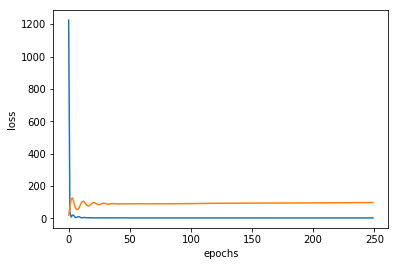

In [9]:
train_loss_history_reduced = [i for idx, i in enumerate(train_loss_history) if idx%2==0]

print(len(train_loss_history_reduced), len(val_loss_history))
plt.plot(list(range(250)), train_loss_history_reduced, '-')
plt.plot(list(range(250)), val_loss_history, '-')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [10]:
overfit_model.double()
overfit_model.cpu()
overfit_model.eval()

image = cv2.imread('DAVIS_2016/DAVIS/Annotations/480p/bear/00001.png')
sample = next(iter(overfit_train_loader))
y = sample.y.detach().numpy()

with torch.no_grad():
    pred = overfit_model(sample).detach().numpy()

contour = np.load('pg_datasets/DAVIS_2016/raw/Contours/bear/00000.npy')

translation_ground_truth = contour + y
translation_pred = contour + pred

In [11]:
def plot_translation(image, translation_ground_truth, translation_pred):
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    ax.scatter(translation_ground_truth[:, 0], translation_ground_truth[:, 1], color='g')
    ax.scatter(translation_pred[:, 0], translation_pred[:, 1], color='r')
    
    # Plot image
    ax.imshow(image)
    
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

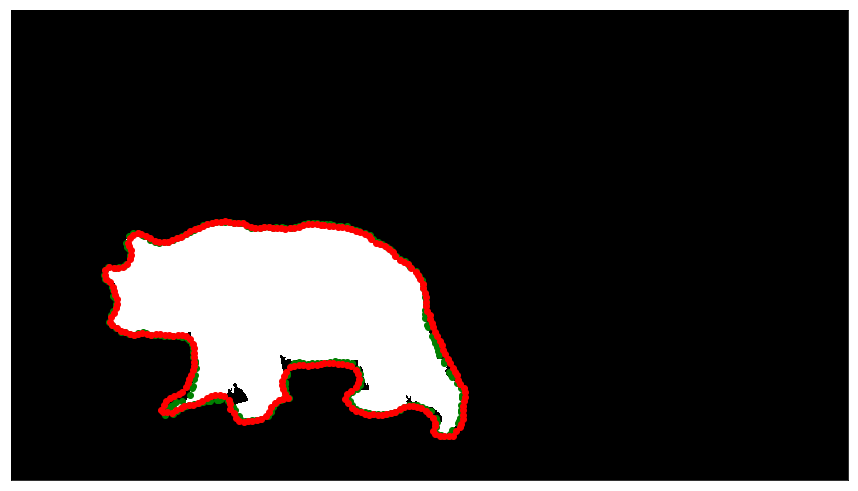

In [12]:
plot_translation(image, translation_ground_truth, translation_pred)

# Combine contour with OSVOS prediction 

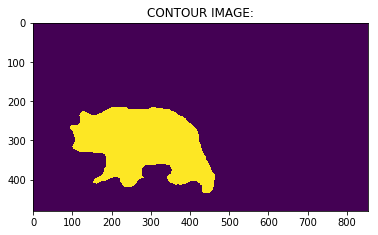

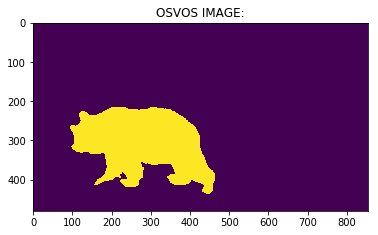

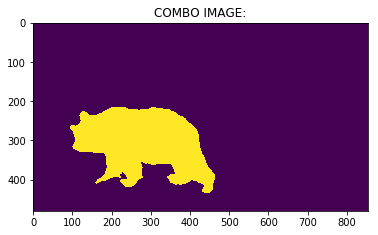

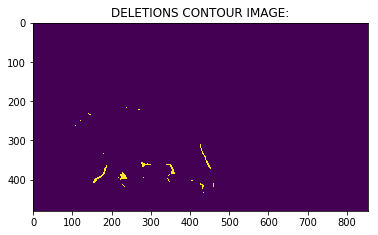

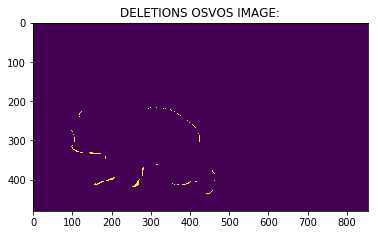

In [28]:
#Get from contourpoints a image --> Example
#print(translation_pred)

contour_img = np.zeros(image.shape)
contour_img = cv2.fillPoly(contour_img, np.int32([translation_pred]), color=(255,255,255))
contour_img = cv2.cvtColor(contour_img.astype(np.float32), cv2.COLOR_RGB2GRAY)

osvos_img = cv2.imread('OSVOS_PyTorch/models/Results/bear/00001.png')
osvos_img = cv2.cvtColor(osvos_img.astype(np.float32), cv2.COLOR_RGB2GRAY)
osvos_img = np.where(osvos_img >= 256/2, 255, 0)

combo_img = np.where(np.logical_and(osvos_img==255, contour_img==255), 1, 0)
deletions_contour_img = np.where(np.logical_and(osvos_img!=255, contour_img==255), 1, 0)
deletions_osvos_img = np.where(np.logical_and(osvos_img==255, contour_img!=255), 1, 0)

plt.title('CONTOUR IMAGE:')
plt.imshow(contour_img)
plt.show()

plt.title('OSVOS IMAGE:')
plt.imshow(osvos_img)
plt.show()

plt.title('COMBO IMAGE:')
plt.imshow(combo_img)
plt.show()

plt.title('DELETIONS CONTOUR IMAGE:')
plt.imshow(deletions_contour_img)
plt.show()

plt.title('DELETIONS OSVOS IMAGE:')
plt.imshow(deletions_osvos_img)
plt.show()

# Train

In [ ]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)
# Load model and run the solver
model = Net(in_channels=train[0].num_features, 
            out_channels=train[0].y.shape[1])
print(model)
model.double()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), 
                       eps=1e-8, weight_decay=0.0)
train_loss_history = train_net(model, train_loader, val_loader, optimizer, criterion,
                               num_epochs=10, log_nth=10, verbose=True)

In [ ]:
plt.plot(train_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# Validate

In [ ]:
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
val_net(model, val_loader, criterion)